In [1]:
print("""
@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 
""")


@Title        : Time Series Analysis and Forecasting
@Author(s)    : Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime  : 2023-12-24 00:39:34
@Description  : 



## Time series decomposition

In [2]:
import pandas as pd
import quandl
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
with open('../../token/quandl.txt', 'r') as f:
    token = f.read()
quandl.ApiConfig.api_key = token

In [3]:
df = (
    pd.read_csv('../data/UNRATENSA.csv', parse_dates=['DATE'], index_col='DATE')
    .rename_axis('Date', axis=0)
    .rename(columns={'UNRATENSA': 'unemp_rate'}))
df.sample(5)

,unemp_rate
Date,
2011-02-01,9.5
2015-10-01,4.8
2014-08-01,6.3
2015-02-01,5.8
2012-03-01,8.4


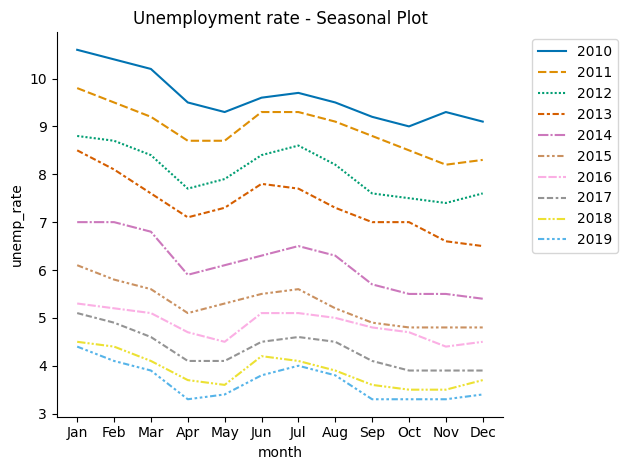

In [4]:
temp_df = df.copy()
temp_df['year'] = temp_df.index.year
temp_df['month'] = temp_df.index.strftime('%b')

sns.lineplot(data=temp_df,
             x='month',
             y='unemp_rate',
             hue='year',
             style='year',
             legend='full',
             palette='colorblind')
plt.title('Unemployment rate - Seasonal Plot')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
sns.despine()
plt.tight_layout()

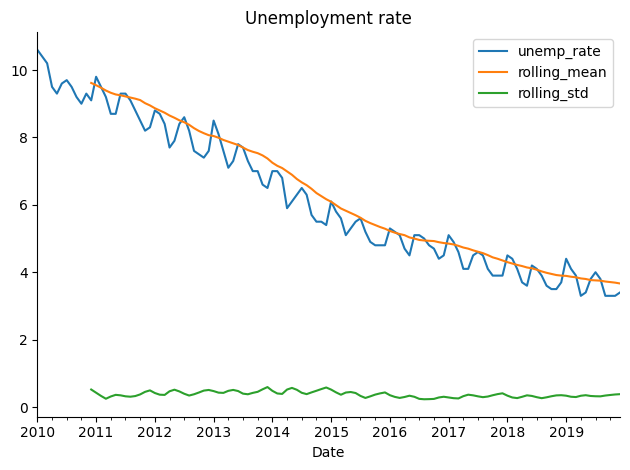

In [5]:
WINDOW_SIZE = 12
df['rolling_mean'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df['unemp_rate'].rolling(window=WINDOW_SIZE).std()

df.plot(title='Unemployment rate')
sns.despine()
plt.tight_layout()

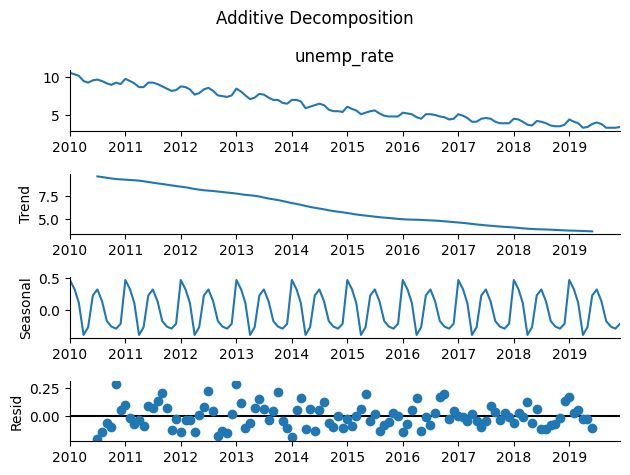

In [6]:
decomposition_results = seasonal_decompose(df['unemp_rate'],
                                           model='additive')
(
    decomposition_results
    .plot()
    .suptitle('Additive Decomposition')
)
sns.despine()
plt.tight_layout()

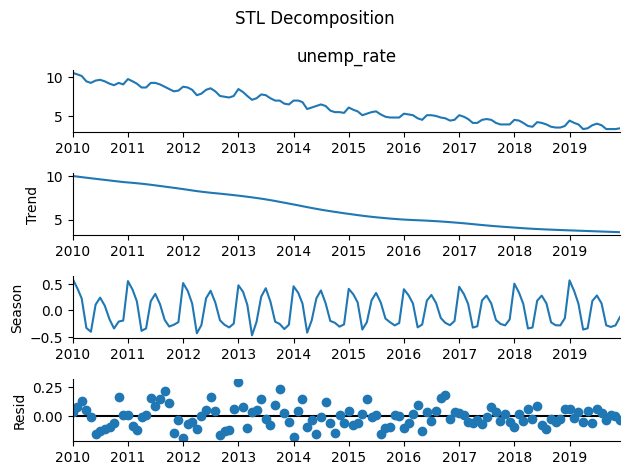

In [7]:
from statsmodels.tsa.seasonal import STL

stl_decomposition = STL(df['unemp_rate']).fit()
stl_decomposition.plot().suptitle('STL Decomposition')
sns.despine()
plt.tight_layout()

比较有鲁棒性和没有鲁棒性的分解

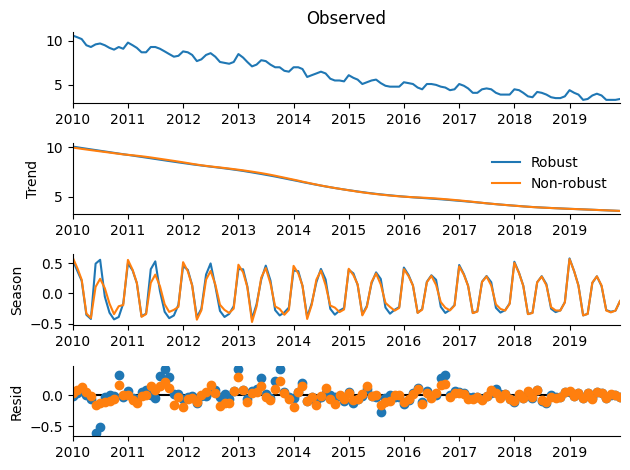

In [8]:
def add_second_stl_to_plot(fig, fitted_stl, labels):
    axs = fig.get_axes()
    comps = ['trend', 'seasonal', 'resid']
    for ax, comp in zip(axs[1:], comps):
        series = getattr(fitted_stl, comp)
        if comp == 'resid':
            ax.plot(series, marker='o', linestyle='none')
        else:
            ax.plot(series)
            if comp == 'trend':
                ax.legend(labels, frameon=False)
                

stl_robust = STL(df[['unemp_rate']], robust=True).fit()
stl_non_robust = STL(df[['unemp_rate']], robust=False).fit()
fig = stl_robust.plot()
add_second_stl_to_plot(fig, stl_non_robust, ['Robust', 'Non-robust'])
sns.despine()
plt.tight_layout()

Hodrick-Prescott 滤波器——虽然这种方法并不是真正的季节性分解方法，但它是一种数据平滑技术，用于消除与经济周期相关的短期波动。 通过消除这些，我们可以揭示长期趋势。 HP 滤波器常用于宏观经济学。 您可以在 `statsmodels` 的 `hpfilter` 函数中找到它的实现。

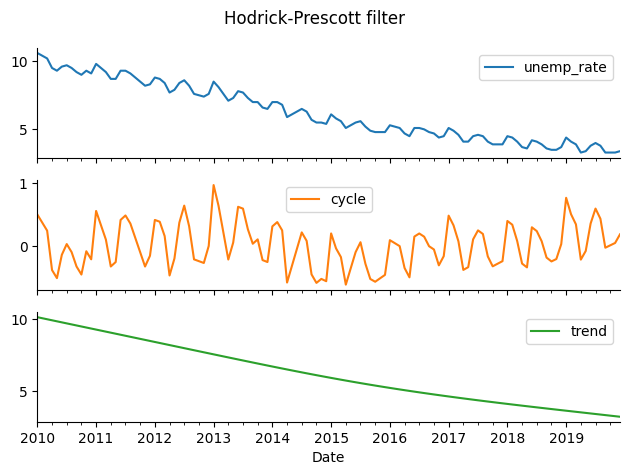

In [9]:
from statsmodels.tsa.filters.hp_filter import hpfilter

hp_df = df[['unemp_rate']].copy()
hp_df['cycle'], hp_df['trend'] = hpfilter(hp_df['unemp_rate'], 129600)
hp_df.plot(subplots=True, title='Hodrick-Prescott filter')

sns.despine()
plt.tight_layout()

## Testing for stationarity in time series

In [10]:
from utils.test import kpss_test, adf_test, test_autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [11]:
adf_test(df['unemp_rate'])

Test Statistic             -2.053411
p-value                     0.263656
# of Lags Used             12.000000
# of Observations Used    107.000000
Critical Value (1%)        -3.492996
Critical Value (5%)        -2.888955
Critical Value (10%)       -2.581393
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary. 

In [12]:
kpss_test(df['unemp_rate'])

Test Statistic           1.799224
p-value                  0.010000
# of lags                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64

The null hypothesis of the KPSS test states that the time series is stationary.

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


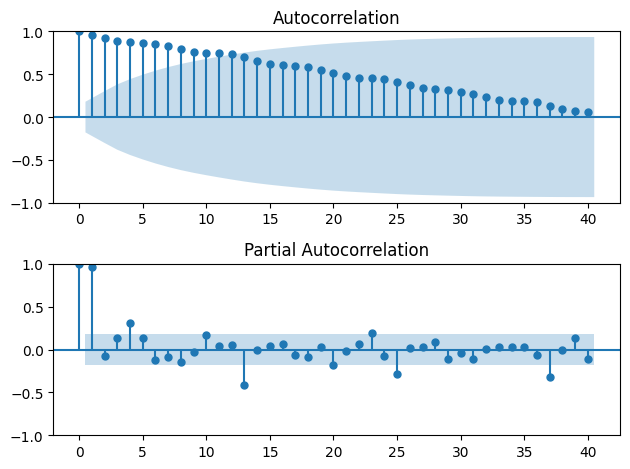

In [13]:
N_LAGS = 40
SIGNIFICANCE_LEVEl = .05
fig, ax = plt.subplots(2, 1)
plot_acf(df['unemp_rate'], ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEl)
plot_pacf(df['unemp_rate'], ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEl)
plt.tight_layout()

### There’s more…

In [14]:
from arch.unitroot import ADF
adf = ADF(df['unemp_rate'])
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.053
P-value                         0.264
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [15]:
from arch.unitroot import ZivotAndrews
za = ZivotAndrews(df['unemp_rate'])
print(za.summary().as_text())

        Zivot-Andrews Results        
Test Statistic                 -2.551
P-value                         0.982
Lags                               12
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.


## Correcting for stationarity in time series

In [16]:
from utils.test import test_autocorrelation
import cpi
from datetime import date
import numpy as np
import pandas as pd

d:\anaconda3\envs\fi\lib\site-packages\cpi\__init__.py:42: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())


In [17]:
df = pd.read_csv('../data/gold_price_data_2000_2010.csv', 
                 parse_dates=['Date'],
                 index_col='Date')

In [18]:
DEAL_DATE = date(2010, 12, 31)

In [19]:
df['dt_index'] = pd.to_datetime(df.index)

In [20]:
df['price_deflated'] = df.apply(
    lambda x: cpi.inflate(x['price'], x['dt_index'], DEAL_DATE), axis=1)

<AxesSubplot:title={'center':'Gold Price (deflated)'}, xlabel='Date'>

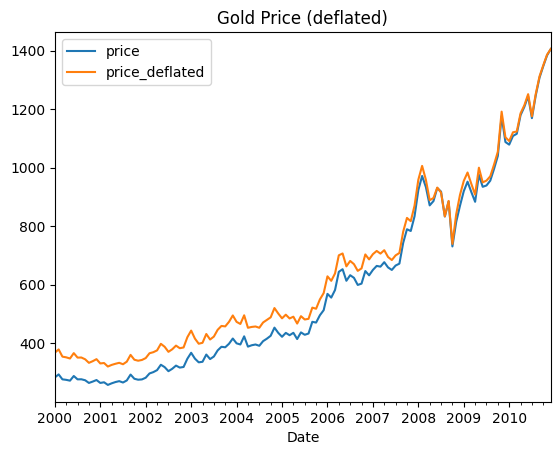

In [21]:
(
    df.loc[:, ['price', 'price_deflated']]
    .plot(title='Gold Price (deflated)')
)

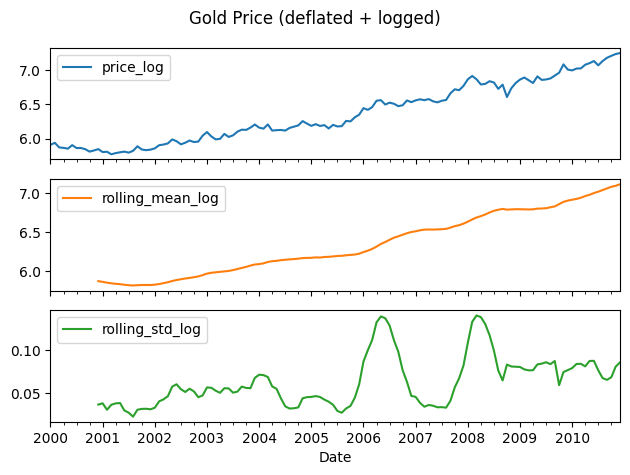

In [22]:
WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log',
                    'rolling_std_log']

df['price_log'] = np.log(df['price_deflated'])
df['rolling_mean_log'] = df['price_log'].rolling(window=WINDOW).mean()
df['rolling_std_log'] = df['price_log'].rolling(window=WINDOW).std()

(
    df[selected_columns]
    .plot(title='Gold Price (deflated + logged)',
          subplots=True)
)
plt.tight_layout()

ADF test statistics: 0.92 (p-val: 0.99)
KPSS test statistic: 1.94 (p-val: 0.01)


d:\anaconda3\envs\fi\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


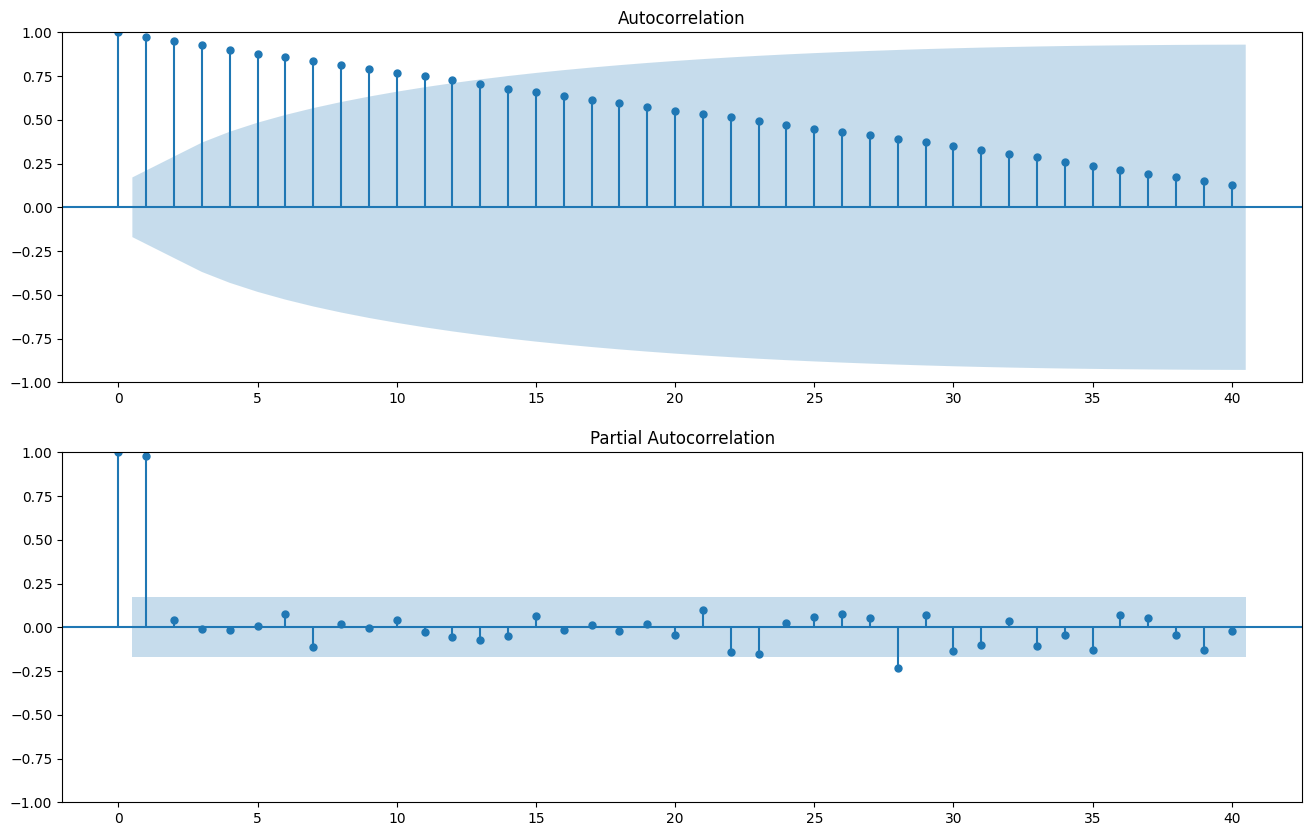

In [23]:
fig = test_autocorrelation(df['price_log'])

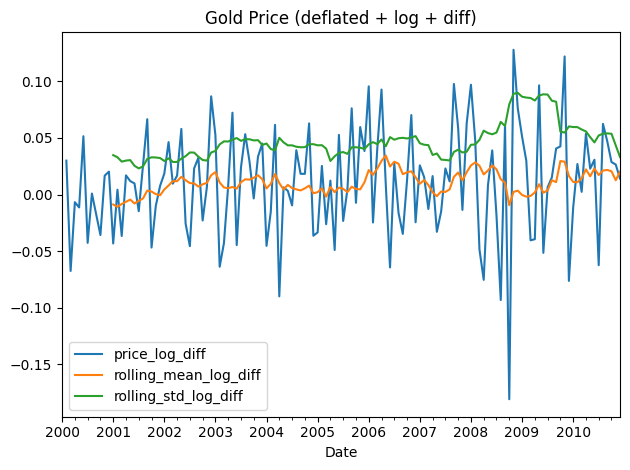

In [24]:
selected_columns = ['price_log_diff', 'rolling_mean_log_diff', 
                    'rolling_std_log_diff']
df['price_log_diff'] = df['price_log'].diff(1)
df['rolling_mean_log_diff'] = df['price_log_diff'].rolling(window=WINDOW).mean()
df['rolling_std_log_diff'] = df['price_log_diff'].rolling(window=WINDOW).std()
df[selected_columns].plot(title='Gold Price (deflated + log + diff)')
plt.tight_layout()

ADF test statistics: -9.45 (p-val: 0.00)
KPSS test statistic: 0.28 (p-val: 0.10)


d:\anaconda3\envs\fi\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


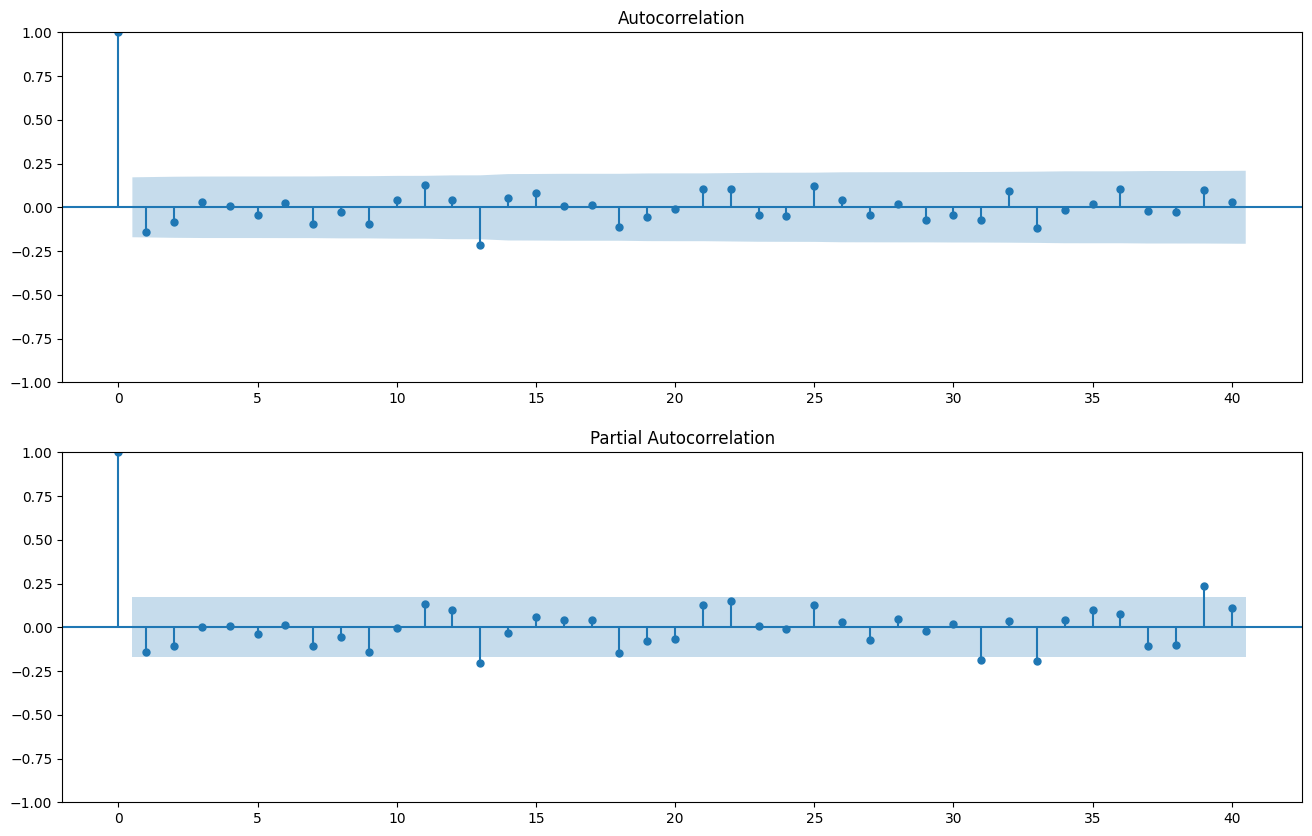

In [25]:
fig = test_autocorrelation(df['price_log_diff'].dropna())

In [26]:
from pmdarima.arima import ndiffs, nsdiffs

print(f"Suggested # of differences (ADF): {ndiffs(df['price'], test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df['price'], test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df['price'], test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1


The library also contains two tests for seasonal differences:
- Osborn, Chui, Smith, and Birchenhall (OCSB)
- Canova-Hansen (CH)

In [27]:
print(f"Suggested # of differences (OSCB): {nsdiffs(df['price'], m=12, test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df['price'], m=12, test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


## 使用指数平滑方法对时间序列建模

In [28]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
df = pd.read_csv('../data/UNRATENSA.csv', index_col='DATE',
                 parse_dates=['DATE'])

In [29]:
TEST_LENGTH = 12
df.index.freq = 'MS'
df_train = df.iloc[:-TEST_LENGTH]
df_test = df.iloc[-TEST_LENGTH:]

In [30]:
ses_1 = SimpleExpSmoothing(df_train).fit(smoothing_level=.5)
# `smoothing_level` 平滑指数，可以手动选择
ses_forecast_1 = ses_1.forecast(TEST_LENGTH)

ses_2 = SimpleExpSmoothing(df_train).fit()
# 平滑指数自动优化，不需要手动选择，基于 SSE
ses_forecast_2 = ses_2.forecast(TEST_LENGTH)

ses_1.params_formatted

,name,param,optimized
smoothing_level,alpha,0.500000,False
initial_level,l.0,10.358112,True


In [31]:
ses_1.summary()

Dep. Variable:,UNRATENSA,No. Observations:,108
Model:,SimpleExpSmoothing,SSE,15.032
Optimized:,True,AIC,-208.973
Trend:,None,BIC,-203.609
Seasonal:,None,AICC,-208.584
Seasonal Periods:,None,Date:,"Tue, 09 Jan 2024"
Box-Cox:,False,Time:,19:42:22
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5000000,alpha,False
initial_level,10.358112,l.0,True


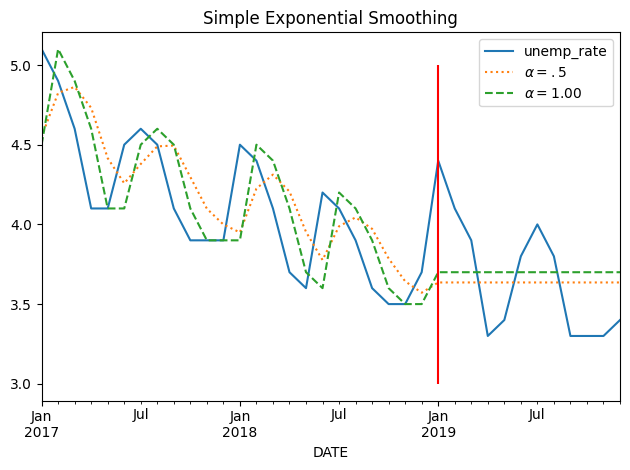

In [32]:
ses_df = df.copy()
ses_df['ses_1'] = ses_1.fittedvalues.append(ses_forecast_1)
ses_df['ses_2'] = ses_2.fittedvalues.append(ses_forecast_2)

opt_alpha = ses_2.model.params['smoothing_level']

fig, ax = plt.subplots()
ses_df['2017':].plot(style=['-', ':', '--'],
                     ax=ax, title='Simple Exponential Smoothing')
labels = ['unemp_rate', r'$\alpha=.5$', r'$\alpha={:.2f}$'.format(opt_alpha)]
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
ax.legend(labels)
plt.tight_layout()

In [33]:
# Holt class (which is a wrapper around the more general ExponentialSmoothing class)
hs_1 = Holt(df_train).fit() # 默认是线性的，自动最优化
hs_forecast_1 = hs_1.forecast(TEST_LENGTH)

hs_2 = Holt(df_train, exponential=True).fit()
hs_forecast_2 = hs_2.forecast(TEST_LENGTH)

hs_3 = Holt(df_train, exponential=False, damped_trend=True).fit()
hs_forecast_3 = hs_3.forecast(TEST_LENGTH)

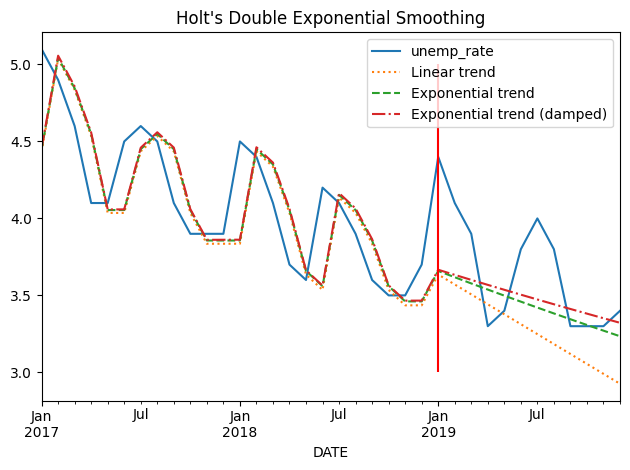

In [34]:
hs_df = df.copy()
hs_df['hs_1'] = hs_1.fittedvalues.append(hs_forecast_1)
hs_df['hs_2'] = hs_2.fittedvalues.append(hs_forecast_2)
hs_df['hs_3'] = hs_3.fittedvalues.append(hs_forecast_3)

fig, ax = plt.subplots()
hs_df['2017':].plot(style=['-', ':', '--', '-.'],
                    ax=ax, title='Holt\'s Double Exponential Smoothing')
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
labels = ['unemp_rate', 'Linear trend', 'Exponential trend', 'Exponential trend (damped)']
ax.legend(labels)
plt.tight_layout()

In [35]:
SEASONAL_PERIODS = 12
hw_1 = ExponentialSmoothing(df_train, trend='mul',
                            seasonal='add', seasonal_periods=SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(TEST_LENGTH)

hw_2 = ExponentialSmoothing(df_train, trend='mul', seasonal='add',
                            seasonal_periods=SEASONAL_PERIODS,
                            damped_trend=True).fit()
hw_forecast_2 = hw_2.forecast(TEST_LENGTH)

When creating an instance of the `ExponentialSmoothing` class, we can additionally pass in the `use_boxcox` argument to automatically apply the Box-Cox transformation to the analyzed time series. Alternatively, we could use the log transformation by passing the "`log`" string to the same argument.

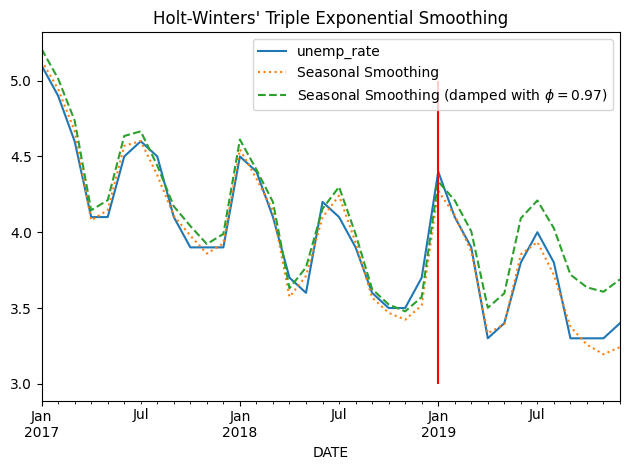

In [36]:
hw_df = df.copy()
hw_df["hw_1"] = hw_1.fittedvalues.append(hw_forecast_1)
hw_df["hw_2"] = hw_2.fittedvalues.append(hw_forecast_2)

fig, ax = plt.subplots()
hw_df["2017":].plot(
    style=["-",":","--"], ax=ax,
    title="Holt-Winters' Triple Exponential Smoothing"
)
phi = hw_2.model.params["damping_trend"]
labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)"
]
ax.vlines(x='2019', ymax=5, ymin=3, color='red')
ax.legend(labels)
plt.tight_layout()

In the preceding plot, we can see that now the seasonal patterns were also incorporated into the forecasts.

### There’s more...

we could approach the task differently, that is, using a procedure called AutoETS. 无需赘述，该过程的目标是根据我们预先提供的一些约束条件，找到最适合的 ETS 模型。

In [37]:
from sktime.forecasting.ets import AutoETS
from sklearn.metrics import mean_absolute_percentage_error

In [44]:
auto_ets = AutoETS(auto=True, n_jobs=1, sp=12)
auto_ets.fit(df_train.to_period())
auto_ets_fcst = auto_ets.predict(fh=list(range(1, 13)))

In [55]:
auto_ets_df = hw_df.to_period().copy()
auto_ets_df['auto_ets'] = (
    auto_ets._fitted_forecaster.fittedvalues.append(auto_ets_fcst['UNRATENSA'])
)

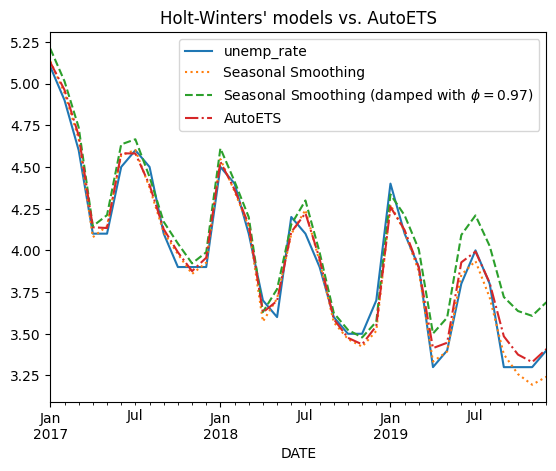

In [57]:
fig, ax = plt.subplots()
auto_ets_df['2017':].plot(
    style=['-', ':', '--', '-.'], ax=ax,
    title='Holt-Winters\' models vs. AutoETS'
)
labels = [
    "unemp_rate",
    "Seasonal Smoothing",
    f"Seasonal Smoothing (damped with $\phi={phi:.2f}$)",
    "AutoETS",
]
ax.legend(labels)

In [65]:
fcst_dict = {
    'Seasonal Smoothing': hw_forecast_1,
    'Seasonal Smoothing (damped)': hw_forecast_2,
    'AutoETS': auto_ets_fcst,
}
print('MAPEs ----')
for key, value in fcst_dict.items():
    mape = mean_absolute_percentage_error(df_test, value)
    print(f'{key:<30}: {100 * mape:.2f}%')

MAPEs ----
Seasonal Smoothing            : 1.81%
Seasonal Smoothing (damped)   : 6.53%
AutoETS                       : 1.78%


## Modeling time series with ARIMA class models

In [163]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from utils.test import test_autocorrelation
from sklearn.metrics import mean_absolute_percentage_error

In [164]:
df = pd.read_csv('../data/UNRATENSA.csv', parse_dates=True, index_col='DATE')
df.columns = ['unemp_rate']
df.index.name = 'date'
df.index.freq = 'MS'

In [166]:
TEST_LENGTH = 12
df_train = df.iloc[:-TEST_LENGTH].copy()
df_test = df.iloc[-TEST_LENGTH:].copy()

In [167]:
df_train.loc[:, ['unemp_rate_log']] = np.log(df_train['unemp_rate'])
df_train.loc[:, ['first_diff']] = df_train['unemp_rate_log'].diff()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

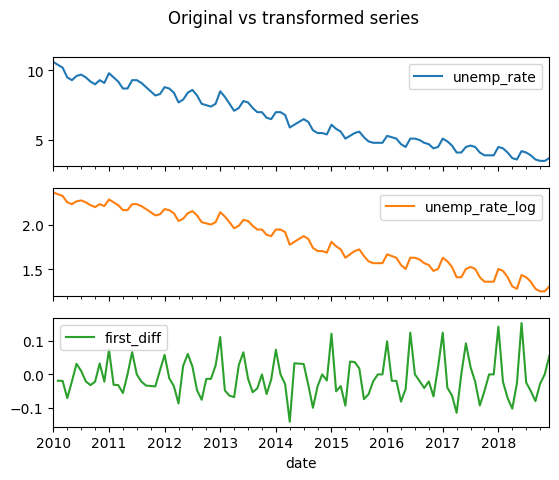

In [168]:
df_train.plot(subplots=True,
              title='Original vs transformed series')

ADF test statistics: -2.97 (p-val: 0.04)
KPSS test statistic: 0.04 (p-val: 0.10)


d:\anaconda3\envs\fi\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


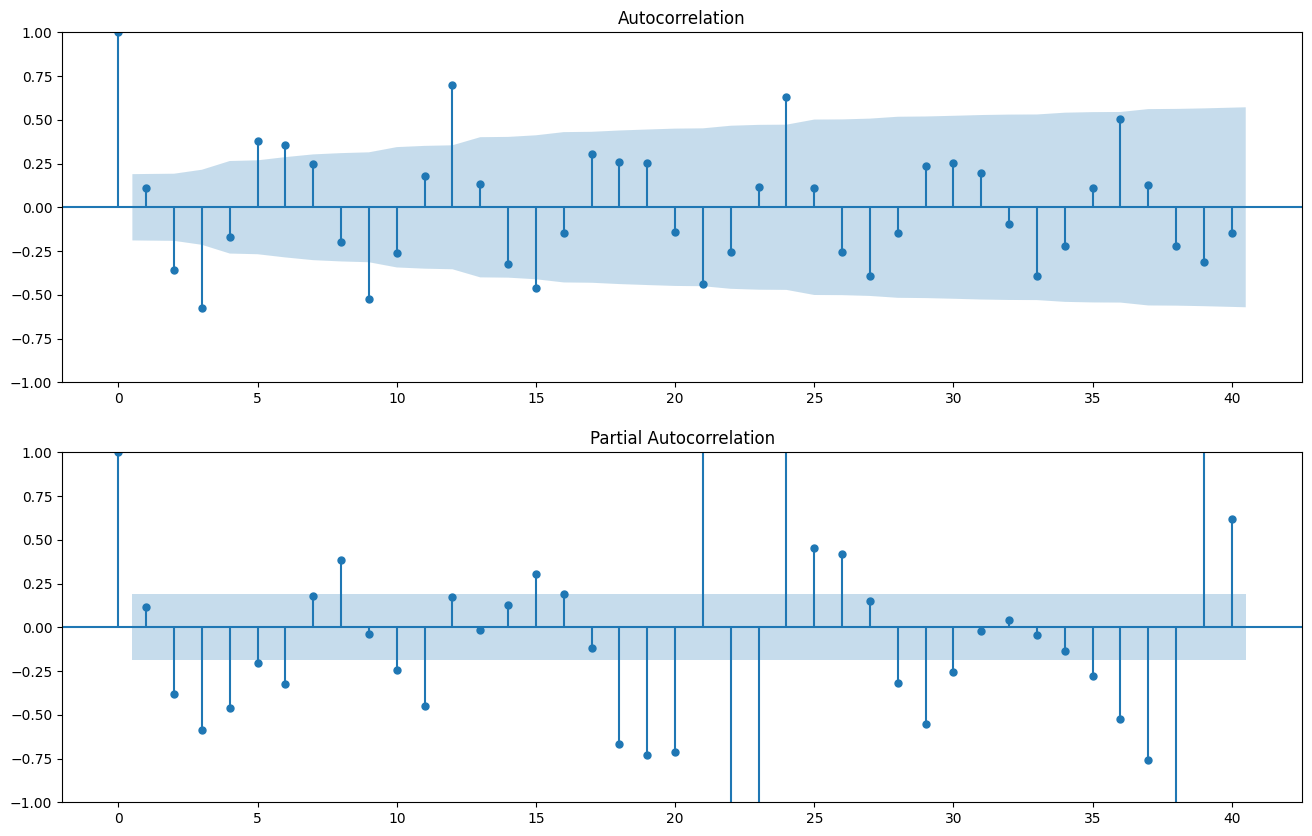

In [169]:
fig = test_autocorrelation(df_train['first_diff'].dropna())

In [171]:
arima_111 = ARIMA(
    df_train['unemp_rate_log'], order=(1, 1, 1)
).fit()
arima_111.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 157.020
Date:                Tue, 09 Jan 2024   AIC                           -308.040
Time:                        20:46:17   BIC                           -300.021
Sample:                    01-01-2010   HQIC                          -304.789
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5541      0.401      1.381      0.167      -0.232       1.340
ma.L1         -0.7315      0.306     -2.392      0.017      -1.331      -0.132
sigma2         0.0031      0.000      6.822      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                 9.59
Prob(Q):                              0.11   Prob(JB):                         0.01
Heteroskedasticity (H):               2.33   Skew:                             0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [172]:
arima_212 = ARIMA(
    df_train['unemp_rate_log'], order=(2, 1, 2)
).fit()
arima_212.summary()

d:\anaconda3\envs\fi\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         unemp_rate_log   No. Observations:                  108
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 196.744
Date:                Tue, 09 Jan 2024   AIC                           -383.488
Time:                        20:47:20   BIC                           -370.124
Sample:                    01-01-2010   HQIC                          -378.070
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9952      0.014     69.592      0.000       0.967       1.023
ar.L2         -0.9893      0.014    -69.967      0.000      -1.017      -0.962
ma.L1         -1.1437     38.080     -0.030      0.976     -75.779      73.492
ma.L2          1.0000     66.596      0.015      0.988    -129.526     131.526
sigma2         0.0014      0.091      0.015      0.988      -0.177       0.180
===================================================================================
Ljung-Box (L1) (Q):                  11.31   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.00   Prob(JB):                         0.20
Heteroskedasticity (H):               1.99   Skew:                             0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [176]:
df['pred_111_log'] = (
    arima_111.fittedvalues.append(arima_111.forecast(TEST_LENGTH))
)
df['pred_111'] = np.exp(df['pred_111_log'])

df['pred_212_log'] = arima_212.fittedvalues.append(arima_212.forecast(TEST_LENGTH))
df['pred_212'] = np.exp(df['pred_212_log'])
df.head()

,unemp_rate,pred_111_log,pred_111,pred_212_log,pred_212
date,,,,,
2010-01-01,10.6,0.000000,1.000000,0.000000,1.000000
2010-02-01,10.4,2.360854,10.600000,2.360854,10.600000
2010-03-01,10.2,2.344579,10.428881,2.337672,10.357096
2010-04-01,9.5,2.327491,10.252191,2.324157,10.218064
2010-05-01,9.3,2.266965,9.650066,2.256342,9.548102


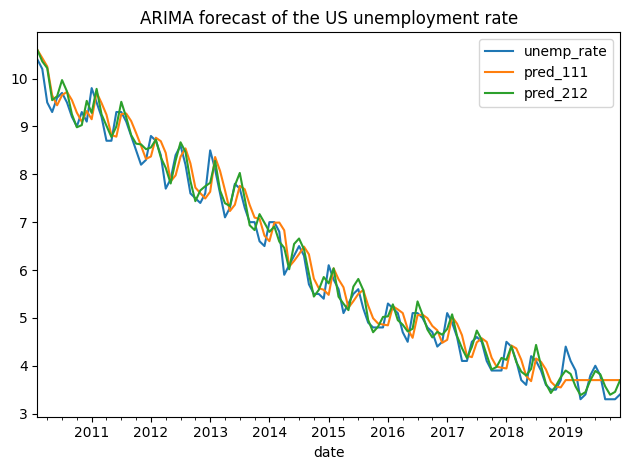

In [179]:
(
    df[['unemp_rate', 'pred_111', 'pred_212']]
    .iloc[1:]
    .plot(title='ARIMA forecast of the US unemployment rate')
)
plt.tight_layout()

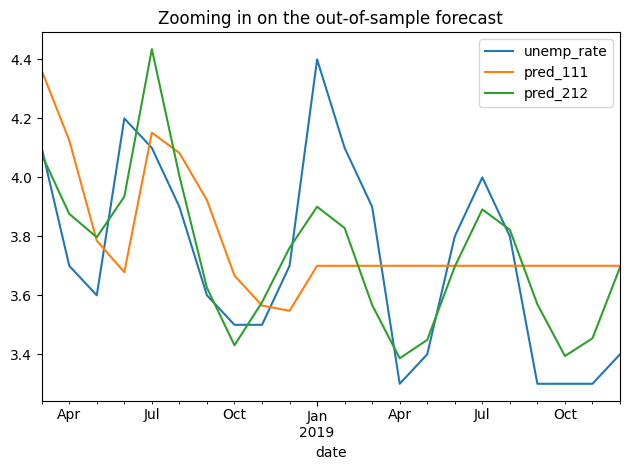

In [182]:
(
    df[['unemp_rate', 'pred_111', 'pred_212']]
    .iloc[-TEST_LENGTH - 10:]
    .plot(title='Zooming in on the out-of-sample forecast')
)
plt.tight_layout()

In [188]:
mape_111 = mean_absolute_percentage_error(
    df['unemp_rate'].iloc[-TEST_LENGTH:],
    df['pred_111'].iloc[-TEST_LENGTH:]
)
mape_212 = mean_absolute_percentage_error(
    df['unemp_rate'].iloc[-TEST_LENGTH:],
    df['pred_212'].iloc[-TEST_LENGTH:]
)

print(f'MAPE of ARIMA(1, 1, 1): {100 * mape_111:.2f}%')
print(f'MAPE of ARIMA(2, 1, 2): {100 * mape_212:.2f}%')

MAPE of ARIMA(1, 1, 1): 9.14%
MAPE of ARIMA(2, 1, 2): 5.08%


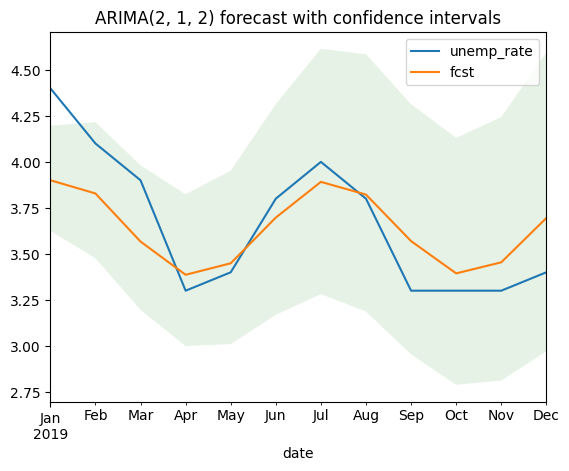

In [199]:
preds_df = arima_212.get_forecast(TEST_LENGTH).summary_frame()
preds_df.columns = ['fcst', 'fcst_me', 'ci_lower', 'ci_upper']
plot_df = df_test[['unemp_rate']].join(np.exp(preds_df))
fig, ax = plt.subplots()
(
    plot_df[['unemp_rate', 'fcst']]
    .plot(ax=ax,
          title='ARIMA(2, 1, 2) forecast with confidence intervals')
)
ax.fill_between(
    plot_df.index,
    plot_df['ci_lower'],
    plot_df['ci_upper'],
    alpha=.1,
    facecolor='g'
)
plt.show()

### There’s more...

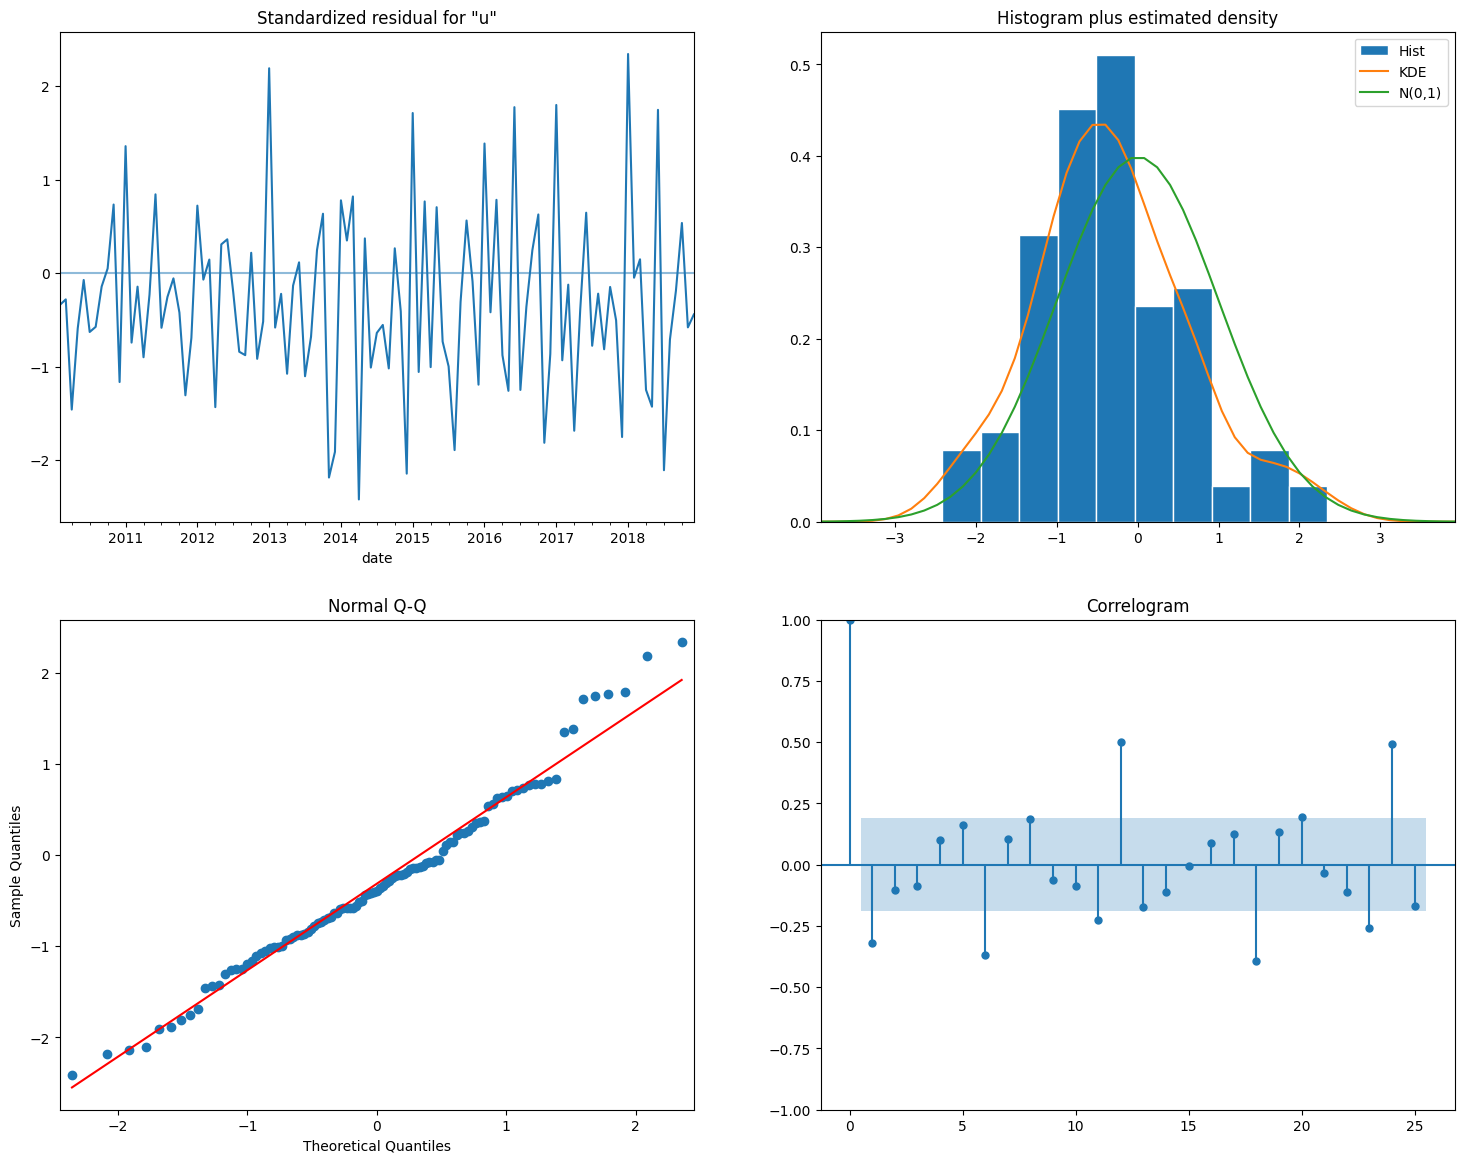

In [209]:
fig = arima_212.plot_diagnostics(figsize=(18, 14), lags=25)

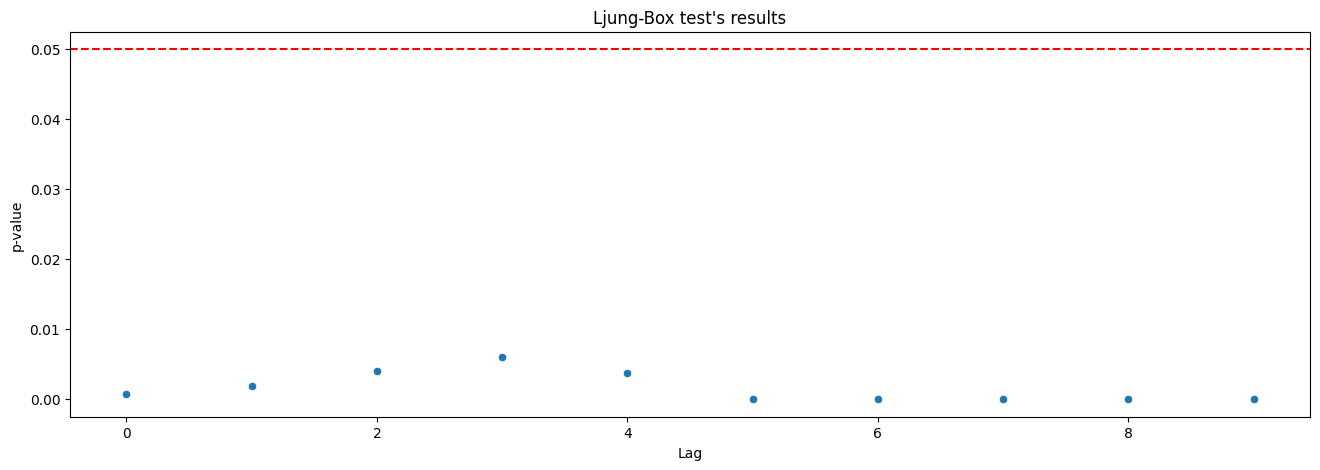

In [216]:
ljung_box_results = arima_212.test_serial_correlation(method='ljungbox')
ljung_box_pvals = ljung_box_results[0][1]

fig, ax = plt.subplots(1, figsize=(16, 5))
sns.scatterplot(x=range(len(ljung_box_pvals)),
                y=ljung_box_pvals,
                ax=ax)
ax.axhline(.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel="Lag",
       ylabel="p-value")
plt.show()

拒绝原假设：残差不存在自相关性，认为存在相关性。

In [218]:
arima_212.test_normality(method='jarquebera')

array([[3.25034998, 0.19687722, 0.4040407 , 3.27578055]])

In [219]:
arima_212.test_heteroskedasticity(method='breakvar')

array([[1.99135216, 0.04210094]])

## Finding the best-fitting ARIMA model with auto-ARIMA